In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sb

import sys
sys.path.insert(1, '../Merging_Data')

import WranglerFunctions as wf
import FullDataset as fd

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from scipy.stats import pearsonr

In [2]:
earnings = pd.read_csv('../Datasets/Financial_dataset/F3METL_Comp.csv', index_col=False, encoding = 'unicode_escape')
earnings = wf.F3Metl_Comp_Wrangler(earnings)
earnings

RIO LN Equity                                                      \
                 PX_OPEN   PX_HIGH    PX_LOW   PX_LAST PX_VOLUME      EBITDA   
Dates                                                                          
2000-01-04      1239.156  1243.287  1210.242  1217.677   3585947   1404.1713   
2000-01-05      1210.242  1218.503  1159.024  1163.981   3342568   1404.1713   
2000-01-06      1173.068  1218.503  1173.068  1205.286   9503906   1404.1713   
2000-01-07      1214.373  1226.764  1185.459  1220.982   7508500   1404.1713   
2000-01-10      1224.286  1226.764  1181.329  1193.720   6438418   1404.1713   
...                  ...       ...       ...       ...       ...         ...   
2022-01-25      5312.000  5353.000  5276.000  5311.000   2538309  19744.0000   
2022-01-26      5422.000  5506.000  5388.000  5434.000   2878571  19744.0000   
2022-01-27      5399.000  5623.000  5384.000  5569.000   2943232  19744.0000   
2022-01-28      5628.000  5665.000  5365.000  5386.000   6162008  19744.0000   
2022-01-31      5400.000  5409.000  5178.000  5185.000   3349054  19744.0000   

                    GLEN LN Equity                  ... EVR LN Equity          \
           PE_RATIO        PX_OPEN PX_HIGH  PX_LOW  ...     PX_VOLUME  EBITDA   
Dates                                               ...                         
2000-01-04  25.8338            NaN     NaN     NaN  ...           NaN     NaN   
2000-01-05  24.7820            NaN     NaN     NaN  ...           NaN     NaN   
2000-01-06  25.6770            NaN     NaN     NaN  ...           NaN     NaN   
2000-01-07  25.8881            NaN     NaN     NaN  ...           NaN     NaN   
2000-01-10  25.3255            NaN     NaN     NaN  ...           NaN     NaN   
...             ...            ...     ...     ...  ...           ...     ...   
2022-01-25   6.1803         391.35  395.00  385.55  ...     3070741.0  2061.0   
2022-01-26   6.3346         394.65  406.00  393.55  ...     2865499.0  2061.0   
2022-01-27   6.4205         393.85  408.25  389.95  ...     2745585.0  2061.0   
2022-01-28   6.2169         402.00  403.00  389.85  ...     3847210.0  2061.0   
2022-01-31   6.0059         397.55  398.40  382.10  ...     2175911.0  2061.0   

                    BHP LN Equity                                            \
           PE_RATIO       PX_OPEN PX_HIGH  PX_LOW PX_LAST  PX_VOLUME EBITDA   
Dates                                                                         
2000-01-04      NaN           NaN     NaN     NaN     NaN        NaN   2489   
2000-01-05      NaN           NaN     NaN     NaN     NaN        NaN   2489   
2000-01-06      NaN           NaN     NaN     NaN     NaN        NaN   2489   
2000-01-07      NaN           NaN     NaN     NaN     NaN        NaN   2489   
2000-01-10      NaN           NaN     NaN     NaN     NaN        NaN   2489   
...             ...           ...     ...     ...     ...        ...    ...   
2022-01-25   6.2323           NaN     NaN     NaN     NaN        NaN  20181   
2022-01-26   6.3396           NaN     NaN     NaN     NaN        NaN  20181   
2022-01-27   6.4637           NaN     NaN     NaN     NaN        NaN  20181   
2022-01-28   6.3724           NaN     NaN     NaN     NaN        NaN  20181   
2022-01-31   6.3604        2426.0  2426.0  2341.5  2347.0  5257964.0  20181   

                     
           PE_RATIO  
Dates                
2000-01-04      NaN  
2000-01-05      NaN  
2000-01-06      NaN  
2000-01-07      NaN  
2000-01-10      NaN  
...             ...  
2022-01-25      NaN  
2022-01-26      NaN  
2022-01-27      NaN  
2022-01-28      NaN  
2022-01-31      NaN  

[5760 rows x 42 columns]

In [3]:
RIO_earnings = earnings['RIO LN Equity']['EBITDA'].to_frame()
RIO_earnings

,EBITDA
Dates,
2000-01-04,1404.1713
2000-01-05,1404.1713
2000-01-06,1404.1713
2000-01-07,1404.1713
2000-01-10,1404.1713
...,...
2022-01-25,19744.0000
2022-01-26,19744.0000
2022-01-27,19744.0000


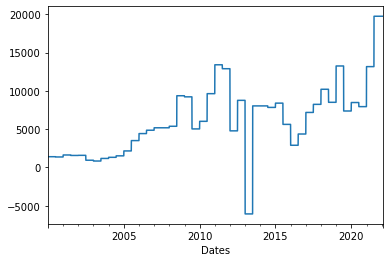

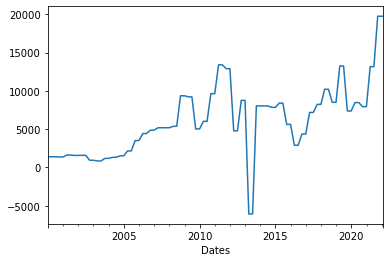

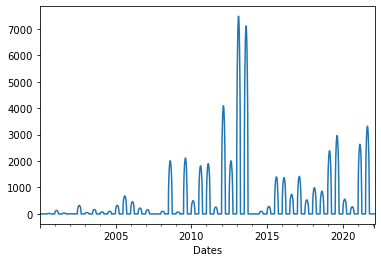

In [4]:
mean = RIO_earnings['EBITDA'].rolling('90D', min_periods=1).mean()
std = RIO_earnings['EBITDA'].rolling('90D', min_periods=1).std()

RIO_earnings['EBITDA'].plot()
plt.show()
mean.plot()
plt.show()
std.plot()
plt.show()

In [5]:
earnings['RIO LN Equity'].loc[earnings['RIO LN Equity']['EBITDA'].drop_duplicates().index].corr()

,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,PX_VOLUME,EBITDA,PE_RATIO
PX_OPEN,1.000000,0.999850,0.999810,0.999484,-0.239973,0.744303,-0.087795
PX_HIGH,0.999850,1.000000,0.999836,0.999794,-0.237720,0.743561,-0.081101
PX_LOW,0.999810,0.999836,1.000000,0.999784,-0.244345,0.739474,-0.088540
PX_LAST,0.999484,0.999794,0.999784,1.000000,-0.243616,0.739113,-0.078522
PX_VOLUME,-0.239973,-0.237720,-0.244345,-0.243616,1.000000,-0.091089,0.142289
EBITDA,0.744303,0.743561,0.739474,0.739113,-0.091089,1.000000,-0.086170
PE_RATIO,-0.087795,-0.081101,-0.088540,-0.078522,0.142289,-0.086170,1.000000


# LSTM

Code inspired from website below:

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

When rerunning code you have to restart the kernel and run from the start.

In [6]:
# inflation_original = pd.read_csv('../Datasets/Economic_dataset/Inflation.csv', index_col = False)
# clean_inflation = wf.Inflation_Unemployment_Wrangler(inflation_original)
# unemployment_original = pd.read_csv('../Datasets/Economic_dataset/Unemployment.csv', index_col = False)
# clean_unemployment, _ = wf.Inflation_Unemployment_Wrangler(unemployment_original)

# def getEBITDAUnique(df, companyName):
#     earnings_unique = df[companyName]['EBITDA'].drop_duplicates()
#     earnings_unique = pd.DataFrame(earnings_unique)
#     earnings_unique = earnings_unique.dropna()
#     earnings_unique = earnings_unique.reset_index()
#     return earnings_unique

# def closest_date(dateList, date, start, end):
#     if start > end:
#         return (start + end) // 2

#     mid = (start + end) // 2
#     if date == dateList[mid]:
#         return mid

#     if date < dateList[mid]:
#         return closest_date(dateList, date, start, mid-1)
#     else:
#         return closest_date(dateList, date, mid+1, end)

# def add_inflation(df, inflation):
#     df['Inflation Rate'] = np.nan
#     i = 0
#     for i in range(len(df)):
#         date = df['Dates'][i]
#         closestInflationDate = closest_date(inflation['Date'], date, 0, len(inflation['Date']))
#         df.loc[i, 'Inflation Rate'] = inflation['Inflation Rate'][closestInflationDate]
#     return df

# def add_Unemployment(df, unemployment):
#     df['Unemployment'] = np.nan
#     i = 0
#     for i in range(len(df)):
#         date = df['Dates'][i]
#         closestDate = closest_date(unemployment['Date'], date, 0, len(unemployment['Date']))
#         df.loc[i, 'Unemployment'] = unemployment['Unemployment Rate'][closestDate]
#     return df

RIO_full = fd.GetFullDatasetForCompany("RIO LN Equity")
RIO_full.index = RIO_full['Date']
RIO_full = RIO_full.drop('Date', axis = 1)
RIO_full

C:\Users\vojno\OneDrive - University of Bristol\Applied Data Science\Mining\Notebooks\Modelling_notebooks\../Merging_Data\WranglerFunctions.py:138: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(location   , index_col=False, names=["Dates", "PX_LAST"])
C:\Users\vojno\OneDrive - University of Bristol\Applied Data Science\Mining\Notebooks\Modelling_notebooks\../Merging_Data\WranglerFunctions.py:138: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(location   , index_col=False, names=["Dates", "PX_LAST"])
C:\Users\vojno\OneDrive - University of Bristol\Applied Data Science\Mining\Notebooks\Modelling_notebooks\../Merging_Data\FullDataset.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

,EBITDA,CL1_COMB_Comodity_PX_LAST,LMAHDS03_LME_Comdty_PX_LAST,LMPBDS03_LME_Comdty_PX_LAST,LMSNDS03_LME_Comdty_PX_LAST,LMCADS03_LME_Comdty_PX_LAST,LMNIDS03_LME_Comdty_PX_LAST,LMCODY_LME_Comdty_PX_LAST,LTBMPRIN_Index_PX_LAST,Inflation Rate,...,SPX500 Index PX_VOLUME,F3METL_PX_LAST,F3METL_PX_VOLUME,GUKG10 Index PX_LAST,BCOMIN_PX_LAST,UK_GDP growth,China_GDP growth,Japan_GDP growth,USA_GDP growth,Shipping costs_Shipping costs
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,1404.1713,25.60,1650.0,495.5,6125.0,1169.92932,5250.27881,39125.0,100.00,1.1,...,1.072386e+09,4188.60,9624338.0,5.662,80.1822,1.0,2.4,7.0,1.5,998.2346
2000-06-30,1369.7180,32.50,1580.0,449.0,5510.0,1180.81665,5310.37646,39125.0,100.00,0.8,...,1.258792e+09,2323.00,9624338.0,5.171,76.2545,0.6,2.4,1.9,7.5,998.2346
2001-01-01,1628.6273,26.80,1565.0,483.0,5195.0,1223.13721,4559.14844,39125.0,100.00,0.8,...,1.318392e+09,1697.10,9624338.0,4.881,74.5400,0.9,2.4,3.0,-1.3,998.2346
2001-07-02,1568.2136,26.25,1473.0,453.0,4625.0,1108.59253,4278.52930,39125.0,100.00,1.7,...,1.256211e+09,1480.40,9624338.0,5.302,66.0225,0.5,2.4,-4.3,-1.6,998.2346
2001-12-31,1583.2303,19.84,1355.0,497.0,3940.0,1023.74707,3848.54346,39125.0,100.00,1.1,...,1.089302e+09,1733.20,9624338.0,5.054,58.5132,0.2,2.4,-1.4,1.1,998.2346
2002-07-01,945.0000,26.86,1388.0,461.0,4460.0,1104.12988,4686.17041,39125.0,100.00,0.6,...,1.590400e+09,2112.30,21369987.0,5.010,63.8257,0.7,2.4,1.3,1.6,998.2346
2002-12-31,840.0000,31.20,1350.0,436.0,4280.0,968.64325,4427.19629,39125.0,100.00,1.7,...,1.084224e+09,656.00,2508529.0,4.374,59.2308,0.9,2.4,1.1,0.5,998.2346
2003-06-30,1178.0000,30.19,1365.0,479.0,4650.0,1001.33105,4967.32813,39125.0,100.00,1.1,...,1.353031e+09,2427.00,37377019.0,4.157,62.0931,0.8,2.4,2.8,3.6,998.2346
2003-12-31,1324.0000,32.52,1600.0,724.0,6525.0,1290.23218,9251.99023,39125.0,100.00,1.3,...,8.362977e+08,4854.00,11824331.0,4.802,84.1474,0.8,2.4,4.4,4.7,998.2346


In [7]:
# RIO_unique = getEBITDAUnique(earnings, "RIO LN Equity")
# add_Unemployment(RIO_unique, clean_unemployment)
# add_inflation(RIO_unique, clean_inflation[0])
# RIO_unique.index = RIO_unique["Dates"]
# RIO_unique = RIO_unique.drop("Dates", axis = 1)
# RIO_unique

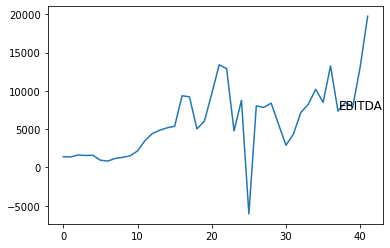

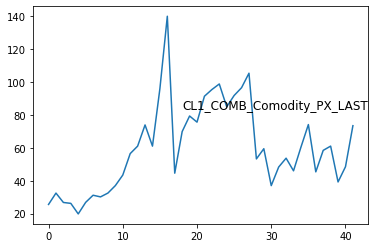

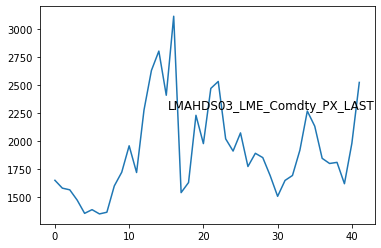

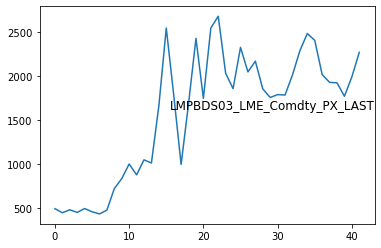

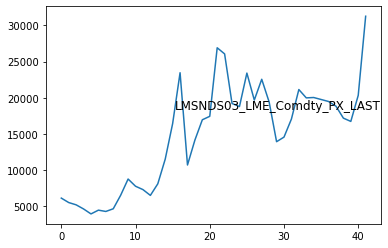

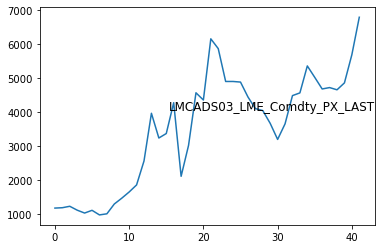

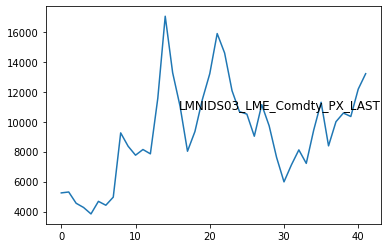

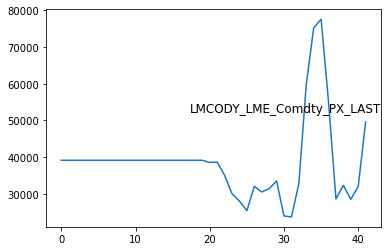

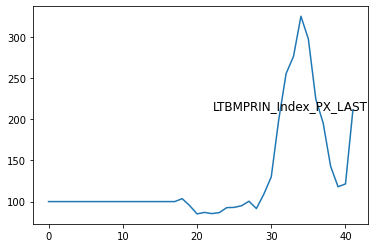

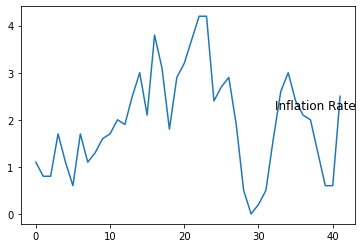

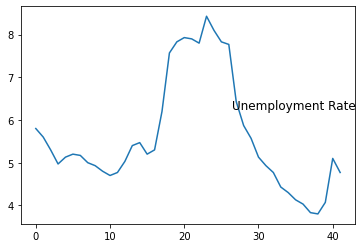

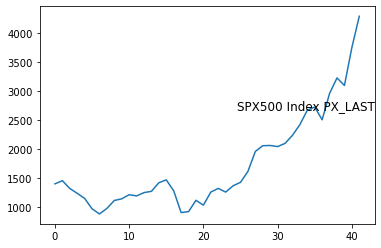

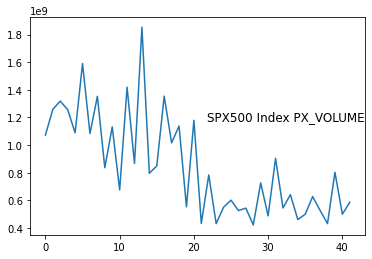

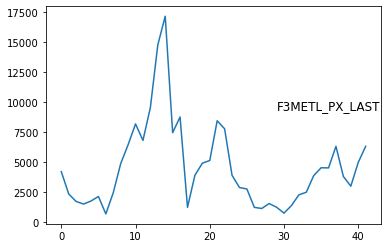

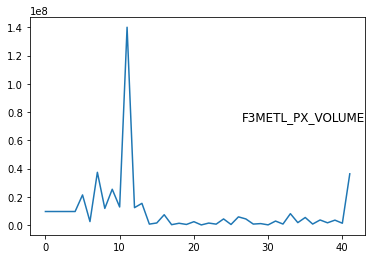

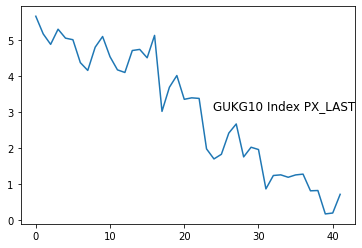

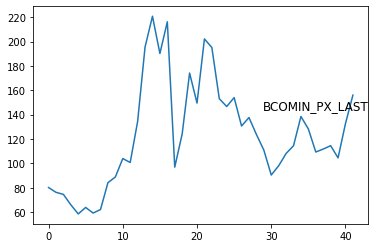

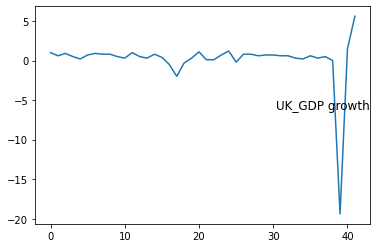

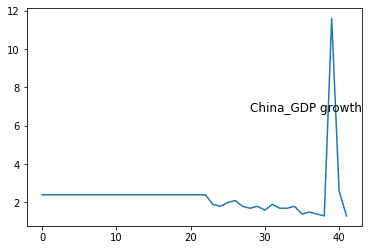

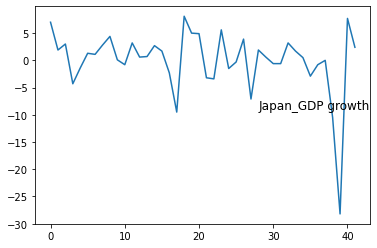

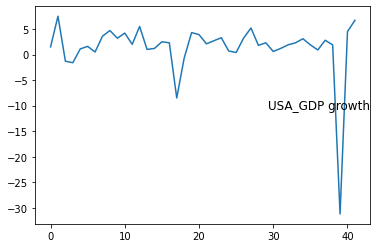

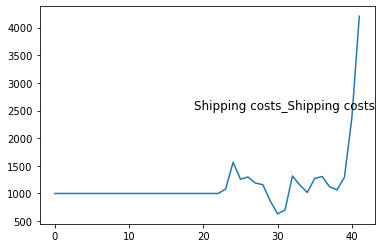

In [8]:
groups = range(len(RIO_full.columns))
i = 1
values = RIO_full.values
# plot each column
# plt.figure()
for group in groups:
#     plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(RIO_full.columns[group], y=0.5, loc='right')
    plt.show()
    i += 1

In [9]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
    
# Lag is number of datapoints it looks previously
lag = 2
reframed = series_to_supervised(scaled, lag, 1)
#reframed.drop(reframed.columns[range(len(RIO_full.columns) + 1, 2*len(RIO_full.columns))], axis=1, inplace=True)
print(list(range(2*len(RIO_full.columns) + 1, 3*len(RIO_full.columns) - 1)))
reframed

[45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]


,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),...,var13(t),var14(t),var15(t),var16(t),var17(t),var18(t),var19(t),var20(t),var21(t),var22(t)
2,0.289429,0.047936,0.170068,0.026468,0.079993,0.034559,0.106346,0.286537,0.062354,0.261905,...,0.626354,0.063055,0.067804,0.857741,0.098763,0.812,0.106796,0.859504,0.772610,0.103356
3,0.288094,0.105360,0.130386,0.005783,0.057478,0.036428,0.110905,0.286537,0.062354,0.190476,...,0.582898,0.049930,0.067804,0.934426,0.046275,0.796,0.106796,0.658402,0.764858,0.103356
4,0.298126,0.057923,0.121882,0.020907,0.045945,0.043694,0.053912,0.286537,0.062354,0.190476,...,0.466253,0.065241,0.067804,0.889253,0.000000,0.784,0.106796,0.738292,0.834625,0.103356
5,0.295785,0.053346,0.069728,0.007562,0.025078,0.024028,0.032622,0.286537,0.062354,0.404762,...,0.816447,0.088202,0.151738,0.881239,0.032737,0.804,0.106796,0.812672,0.847545,0.103356
6,0.296367,0.000000,0.002834,0.027135,0.000000,0.009461,0.000000,0.286537,0.062354,0.261905,...,0.462705,0.000000,0.016955,0.765392,0.004422,0.812,0.106796,0.807162,0.819121,0.103356
7,0.271639,0.058422,0.021542,0.011121,0.019037,0.023262,0.063548,0.286537,0.062354,0.142857,...,0.650561,0.107262,0.266123,0.725865,0.022061,0.808,0.106796,0.853994,0.899225,0.103356
8,0.267571,0.094541,0.000000,0.000000,0.012447,0.000000,0.043901,0.286537,0.062354,0.404762,...,0.289441,0.254255,0.083525,0.843351,0.157967,0.808,0.106796,0.898072,0.927649,0.103356
9,0.280666,0.086135,0.008503,0.019128,0.025993,0.005612,0.084879,0.286537,0.062354,0.261905,...,0.495718,0.349803,0.180412,0.897450,0.186792,0.796,0.106796,0.779614,0.888889,0.103356
10,0.286323,0.105526,0.141723,0.128114,0.094637,0.055213,0.409944,0.286537,0.062354,0.309524,...,0.177065,0.455145,0.090766,0.795082,0.280036,0.788,0.106796,0.754821,0.914729,0.103356
11,0.293801,0.143226,0.210884,0.178381,0.176460,0.084453,0.342548,0.286537,0.062354,0.380952,...,0.696806,0.371849,1.000000,0.728779,0.260203,0.816,0.106796,0.865014,0.857881,0.103356


In [10]:
# split into train and test sets
values = reframed.values
n_train_hours = 30
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = lag * 22
train_X, train_y = train[:, :n_obs], train[:, -22]
test_X, test_y = test[:, :n_obs], test[:, -22]
# reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], lag, train_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0], lag, test_X.shape[1]))

train_X = train_X.reshape((train_X.shape[0], lag, 22))
test_X = test_X.reshape((test_X.shape[0], lag, 22))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(30, 2, 22) (30,) (10, 2, 22) (10,)


Epoch 1/50
1/1 - 1s - loss: 0.3144 - val_loss: 0.5319
Epoch 2/50
1/1 - 0s - loss: 0.2746 - val_loss: 0.4891
Epoch 3/50
1/1 - 0s - loss: 0.2345 - val_loss: 0.4461
Epoch 4/50
1/1 - 0s - loss: 0.1940 - val_loss: 0.4026
Epoch 5/50
1/1 - 0s - loss: 0.1532 - val_loss: 0.3587
Epoch 6/50
1/1 - 0s - loss: 0.1141 - val_loss: 0.3147
Epoch 7/50
1/1 - 0s - loss: 0.0940 - val_loss: 0.2734
Epoch 8/50
1/1 - 0s - loss: 0.0906 - val_loss: 0.2374
Epoch 9/50
1/1 - 0s - loss: 0.0929 - val_loss: 0.2059
Epoch 10/50
1/1 - 0s - loss: 0.0985 - val_loss: 0.1812
Epoch 11/50
1/1 - 0s - loss: 0.1083 - val_loss: 0.1653
Epoch 12/50
1/1 - 0s - loss: 0.1156 - val_loss: 0.1590
Epoch 13/50
1/1 - 0s - loss: 0.1199 - val_loss: 0.1596
Epoch 14/50
1/1 - 0s - loss: 0.1181 - val_loss: 0.1660
Epoch 15/50
1/1 - 0s - loss: 0.1114 - val_loss: 0.1789
Epoch 16/50
1/1 - 0s - loss: 0.1020 - val_loss: 0.1949
Epoch 17/50
1/1 - 0s - loss: 0.0923 - val_loss: 0.2120
Epoch 18/50
1/1 - 0s - loss: 0.0844 - val_loss: 0.2299
Epoch 19/50
1/1 - 0

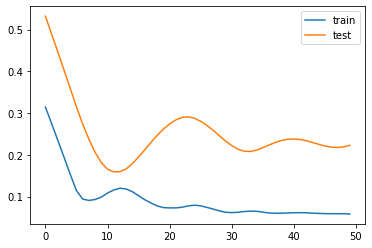

In [11]:
# design network
model = Sequential()
lstm = LSTM(50, input_shape = (train_X.shape[1], train_X.shape[2]))
model.add(lstm)
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [12]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], lag*22))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -21:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -21:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 7360.602


## Plotting forecast

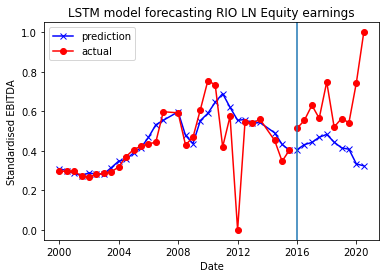

In [13]:
yhatTrain = model.predict(train_X)
plt.plot(RIO_full.index[:30], yhatTrain, c = 'b', marker = 'x')
plt.plot(RIO_full.index[:30], train_y, c = 'r', marker = 'o')

plt.plot(RIO_full.index[30:40], yhat, c = 'b', marker = 'x')
plt.plot(RIO_full.index[30:40], test_y, c = 'r', marker = 'o')

labels = ["prediction", "actual"]
plt.legend(labels)
plt.title("LSTM model forecasting RIO LN Equity earnings")
plt.axvline(RIO_full.index[30])
plt.ylabel("Standardised EBITDA")
plt.xlabel("Date")
plt.rcParams["figure.figsize"] = (8, 6)
plt.show()

## Running LSTM with important features

In [14]:
# Calculating which correlations are statistically significant
# We choose a p-value of 0.05
# Null hypothesis is if x and y are unrelated - Anything below a p-value 0.05, means that this hypothesis is rejected.

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

In [15]:
pvalues = calculate_pvalues(RIO_full)
statisticallySignificant = pvalues <= 0.05
discardedColumns = statisticallySignificant[statisticallySignificant['EBITDA'].values == False].index

In [16]:
RIO_bestFeatures = RIO_full.drop(discardedColumns, axis = 1)
RIO_bestFeatures

,EBITDA,CL1_COMB_Comodity_PX_LAST,LMAHDS03_LME_Comdty_PX_LAST,LMPBDS03_LME_Comdty_PX_LAST,LMSNDS03_LME_Comdty_PX_LAST,LMCADS03_LME_Comdty_PX_LAST,LMNIDS03_LME_Comdty_PX_LAST,LTBMPRIN_Index_PX_LAST,Inflation Rate,SPX500 Index PX_LAST,SPX500 Index PX_VOLUME,GUKG10 Index PX_LAST,BCOMIN_PX_LAST,Shipping costs_Shipping costs
Date,,,,,,,,,,,,,,
2000-01-04,1404.1713,25.60,1650.0,495.5,6125.0,1169.92932,5250.27881,100.00,1.1,1399.42,1.072386e+09,5.662,80.1822,998.2346
2000-06-30,1369.7180,32.50,1580.0,449.0,5510.0,1180.81665,5310.37646,100.00,0.8,1454.60,1.258792e+09,5.171,76.2545,998.2346
2001-01-01,1628.6273,26.80,1565.0,483.0,5195.0,1223.13721,4559.14844,100.00,0.8,1320.28,1.318392e+09,4.881,74.5400,998.2346
2001-07-02,1568.2136,26.25,1473.0,453.0,4625.0,1108.59253,4278.52930,100.00,1.7,1236.71,1.256211e+09,5.302,66.0225,998.2346
2001-12-31,1583.2303,19.84,1355.0,497.0,3940.0,1023.74707,3848.54346,100.00,1.1,1148.08,1.089302e+09,5.054,58.5132,998.2346
2002-07-01,945.0000,26.86,1388.0,461.0,4460.0,1104.12988,4686.17041,100.00,0.6,968.65,1.590400e+09,5.010,63.8257,998.2346
2002-12-31,840.0000,31.20,1350.0,436.0,4280.0,968.64325,4427.19629,100.00,1.7,879.82,1.084224e+09,4.374,59.2308,998.2346
2003-06-30,1178.0000,30.19,1365.0,479.0,4650.0,1001.33105,4967.32813,100.00,1.1,974.50,1.353031e+09,4.157,62.0931,998.2346
2003-12-31,1324.0000,32.52,1600.0,724.0,6525.0,1290.23218,9251.99023,100.00,1.3,1111.92,8.362977e+08,4.802,84.1474,998.2346


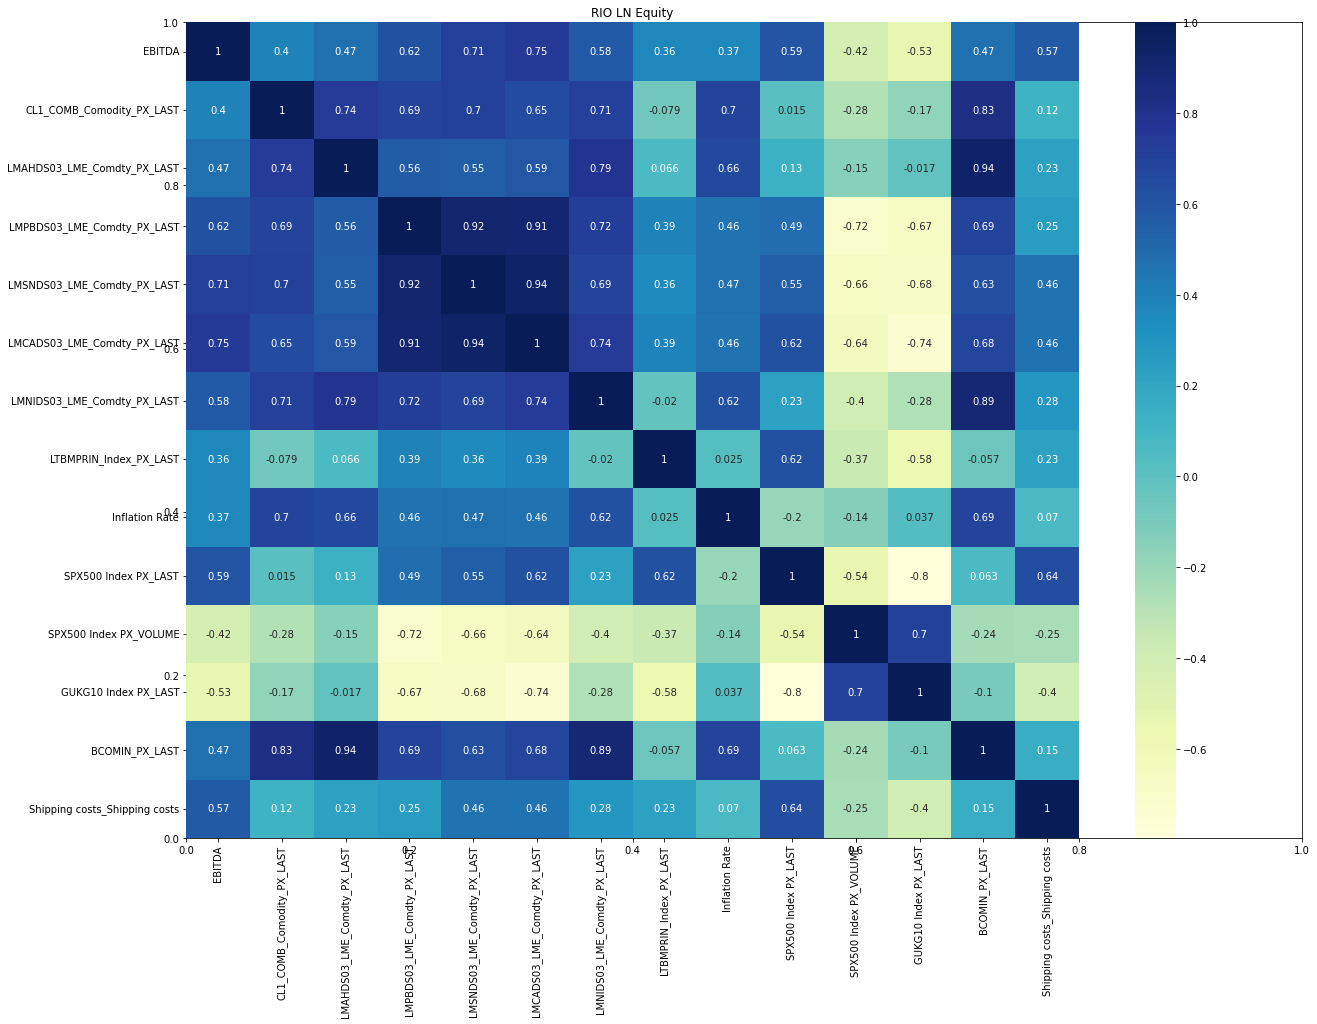

In [17]:
plt.subplots(figsize=(20,15))
ax = plt.axes()
ax.set_title("RIO LN Equity")
heatmap = sb.heatmap(RIO_bestFeatures.corr(), cmap="YlGnBu", annot=True)

In [18]:
values = RIO_bestFeatures.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
    
# Lag is number of datapoints it looks previously
lag = 2
reframed = series_to_supervised(scaled, lag, 1)
#reframed.drop(reframed.columns[range(len(RIO_full.columns) + 1, 2*len(RIO_full.columns))], axis=1, inplace=True)
print(list(range(2*len(RIO_bestFeatures.columns) + 1, 3*len(RIO_bestFeatures.columns) - 1)))
reframed

[29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),...,var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t),var14(t)
2,0.289429,0.047936,0.170068,0.026468,0.079993,0.034559,0.106346,0.062354,0.261905,0.152033,...,0.045945,0.043694,0.053912,0.062354,0.190476,0.128877,0.626354,0.857741,0.098763,0.103356
3,0.288094,0.105360,0.130386,0.005783,0.057478,0.036428,0.110905,0.062354,0.190476,0.168178,...,0.025078,0.024028,0.032622,0.062354,0.404762,0.104425,0.582898,0.934426,0.046275,0.103356
4,0.298126,0.057923,0.121882,0.020907,0.045945,0.043694,0.053912,0.062354,0.190476,0.128877,...,0.000000,0.009461,0.000000,0.062354,0.261905,0.078492,0.466253,0.889253,0.000000,0.103356
5,0.295785,0.053346,0.069728,0.007562,0.025078,0.024028,0.032622,0.062354,0.404762,0.104425,...,0.019037,0.023262,0.063548,0.062354,0.142857,0.025991,0.816447,0.881239,0.032737,0.103356
6,0.296367,0.000000,0.002834,0.027135,0.000000,0.009461,0.000000,0.062354,0.261905,0.078492,...,0.012447,0.000000,0.043901,0.062354,0.404762,0.000000,0.462705,0.765392,0.004422,0.103356
7,0.271639,0.058422,0.021542,0.011121,0.019037,0.023262,0.063548,0.062354,0.142857,0.025991,...,0.025993,0.005612,0.084879,0.062354,0.261905,0.027703,0.650561,0.725865,0.022061,0.103356
8,0.267571,0.094541,0.000000,0.000000,0.012447,0.000000,0.043901,0.062354,0.404762,0.000000,...,0.094637,0.055213,0.409944,0.062354,0.309524,0.067912,0.289441,0.843351,0.157967,0.103356
9,0.280666,0.086135,0.008503,0.019128,0.025993,0.005612,0.084879,0.062354,0.261905,0.027703,...,0.176460,0.084453,0.342548,0.062354,0.380952,0.076373,0.495718,0.897450,0.186792,0.103356
10,0.286323,0.105526,0.141723,0.128114,0.094637,0.055213,0.409944,0.062354,0.309524,0.067912,...,0.140033,0.115990,0.297083,0.062354,0.404762,0.097171,0.177065,0.795082,0.280036,0.103356
11,0.293801,0.143226,0.210884,0.178381,0.176460,0.084453,0.342548,0.062354,0.380952,0.076373,...,0.123009,0.151719,0.325781,0.062354,0.476191,0.091147,0.696806,0.728779,0.260203,0.103356


In [19]:
# split into train and test sets
values = reframed.values
n_train_hours = 30
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = lag * len(RIO_bestFeatures.columns)
train_X, train_y = train[:, :n_obs], train[:, -len(RIO_bestFeatures.columns)]
test_X, test_y = test[:, :n_obs], test[:, -len(RIO_bestFeatures.columns)]
# reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], lag, train_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0], lag, test_X.shape[1]))

train_X = train_X.reshape((train_X.shape[0], lag, len(RIO_bestFeatures.columns)))
test_X = test_X.reshape((test_X.shape[0], lag, len(RIO_bestFeatures.columns)))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(30, 2, 14) (30,) (10, 2, 14) (10,)


Epoch 1/50
1/1 - 1s - loss: 0.1899 - val_loss: 0.4009
Epoch 2/50
1/1 - 0s - loss: 0.1609 - val_loss: 0.3660
Epoch 3/50
1/1 - 0s - loss: 0.1359 - val_loss: 0.3309
Epoch 4/50
1/1 - 0s - loss: 0.1125 - val_loss: 0.2955
Epoch 5/50
1/1 - 0s - loss: 0.0912 - val_loss: 0.2601
Epoch 6/50
1/1 - 0s - loss: 0.0760 - val_loss: 0.2256
Epoch 7/50
1/1 - 0s - loss: 0.0738 - val_loss: 0.1960
Epoch 8/50
1/1 - 0s - loss: 0.0786 - val_loss: 0.1730
Epoch 9/50
1/1 - 0s - loss: 0.0849 - val_loss: 0.1599
Epoch 10/50
1/1 - 0s - loss: 0.0906 - val_loss: 0.1555
Epoch 11/50
1/1 - 0s - loss: 0.0934 - val_loss: 0.1548
Epoch 12/50
1/1 - 0s - loss: 0.0925 - val_loss: 0.1572
Epoch 13/50
1/1 - 0s - loss: 0.0886 - val_loss: 0.1627
Epoch 14/50
1/1 - 0s - loss: 0.0834 - val_loss: 0.1711
Epoch 15/50
1/1 - 0s - loss: 0.0784 - val_loss: 0.1828
Epoch 16/50
1/1 - 0s - loss: 0.0747 - val_loss: 0.1946
Epoch 17/50
1/1 - 0s - loss: 0.0718 - val_loss: 0.2065
Epoch 18/50
1/1 - 0s - loss: 0.0694 - val_loss: 0.2180
Epoch 19/50
1/1 - 0

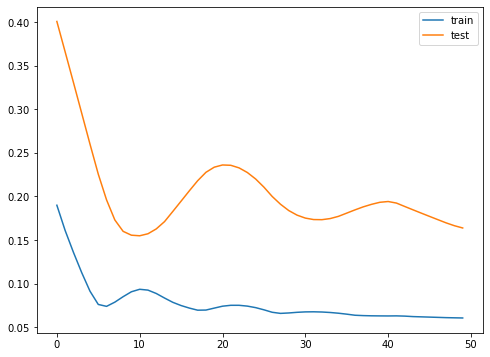

In [20]:
# design network
model = Sequential()
lstm = LSTM(50, input_shape = (train_X.shape[1], train_X.shape[2]))
model.add(lstm)
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [21]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], lag*len(RIO_bestFeatures.columns)))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -len(RIO_bestFeatures.columns) + 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -len(RIO_bestFeatures.columns) + 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)
rmseFullFeatures = rmse

Test RMSE: 0.229


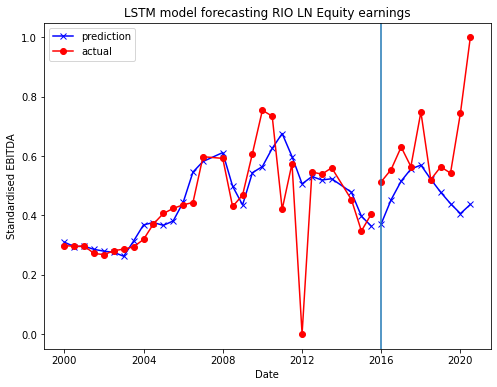

In [22]:
yhatTrain = model.predict(train_X)
plt.plot(RIO_bestFeatures.index[:30], yhatTrain, c = 'b', marker = 'x')
plt.plot(RIO_bestFeatures.index[:30], train_y, c = 'r', marker = 'o')

plt.plot(RIO_bestFeatures.index[30:40], yhat, c = 'b', marker = 'x')
plt.plot(RIO_bestFeatures.index[30:40], test_y, c = 'r', marker = 'o')

labels = ["prediction", "actual"]
plt.legend(labels)
plt.title("LSTM model forecasting RIO LN Equity earnings")
plt.axvline(RIO_bestFeatures.index[30])
plt.ylabel("Standardised EBITDA")
plt.xlabel("Date")
plt.rcParams["figure.figsize"] = (8, 6)
plt.show()

In [23]:
corr = RIO_full.corr()
discardedColumns = []
for column_idx in range(1, len(RIO_full.columns)):
    for row_idx in range (1, len(RIO_full.columns)):
        if (row_idx != column_idx):
            if (corr[corr.columns[column_idx]].loc[corr.columns[row_idx]] > 0.8):
                if (abs(corr['EBITDA'].loc[corr.columns[column_idx]]) > abs(corr['EBITDA'].loc[corr.columns[row_idx]])):
                    if (not corr.columns[row_idx] in discardedColumns):
                        discardedColumns.append(corr.columns[row_idx])
                else:
                    if (not corr.columns[column_idx] in discardedColumns):
                        discardedColumns.append(corr.columns[column_idx])
        else:
            break
discardedColumns

['LMPBDS03_LME_Comdty_PX_LAST',
 'LMSNDS03_LME_Comdty_PX_LAST',
 'CL1_COMB_Comodity_PX_LAST',
 'LMAHDS03_LME_Comdty_PX_LAST',
 'BCOMIN_PX_LAST',
 'USA_GDP growth']

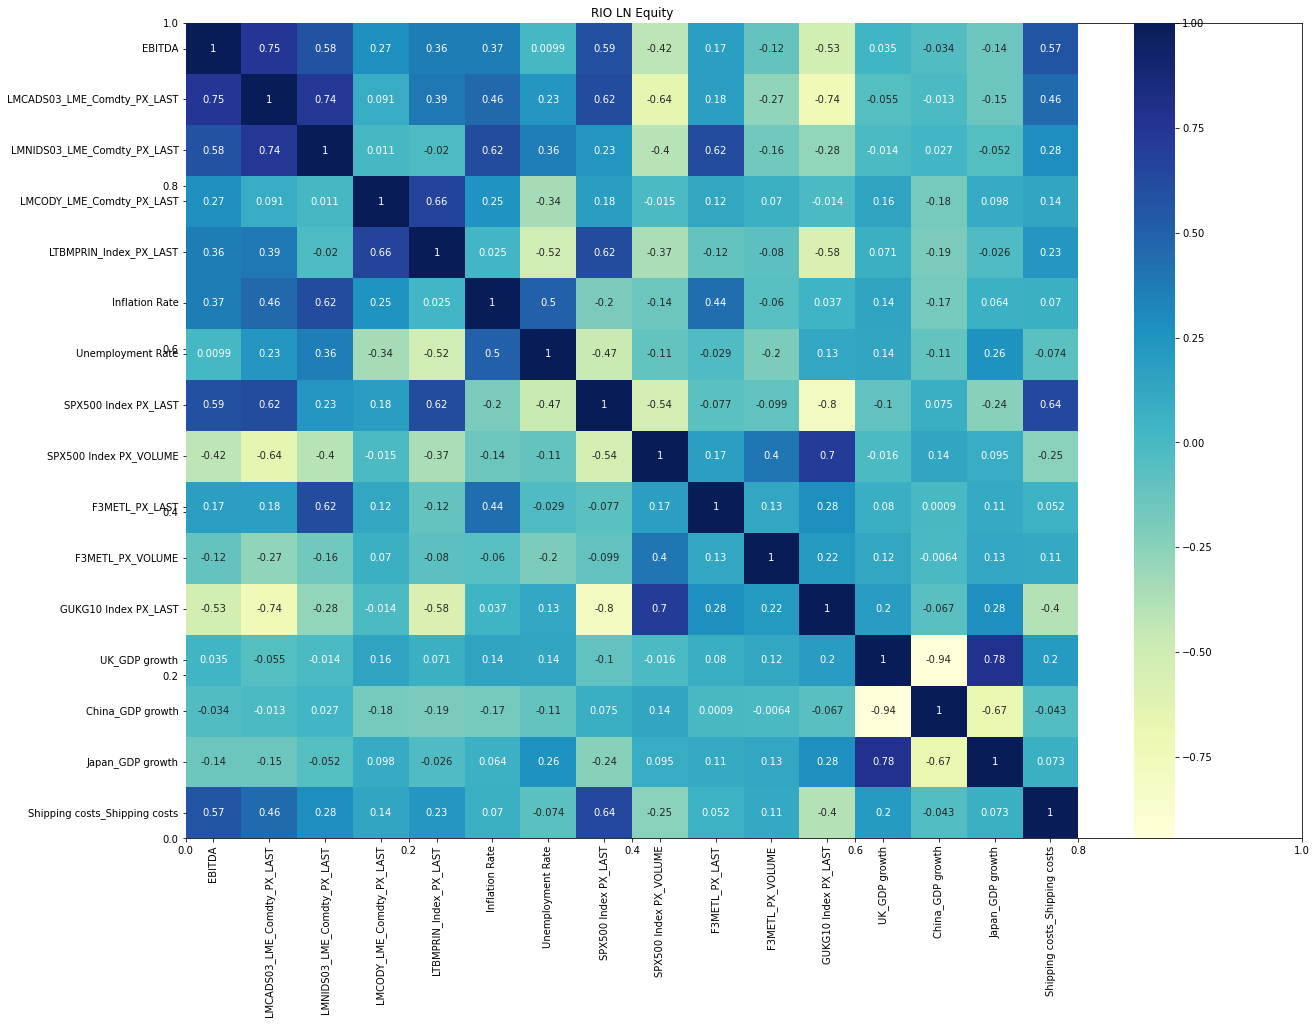

In [24]:
RIO_removedInterCorrelation = RIO_full.drop(discardedColumns, axis = 1)
plt.subplots(figsize=(20,15))
ax = plt.axes()
ax.set_title("RIO LN Equity")
heatmap = sb.heatmap(RIO_removedInterCorrelation.corr(), cmap="YlGnBu", annot=True)

In [25]:
pvalues = calculate_pvalues(RIO_removedInterCorrelation)
statisticallySignificant = pvalues <= 0.05
discardedColumns = statisticallySignificant[statisticallySignificant['EBITDA'].values == False].index
RIO_final = RIO_removedInterCorrelation.drop(discardedColumns, axis = 1)

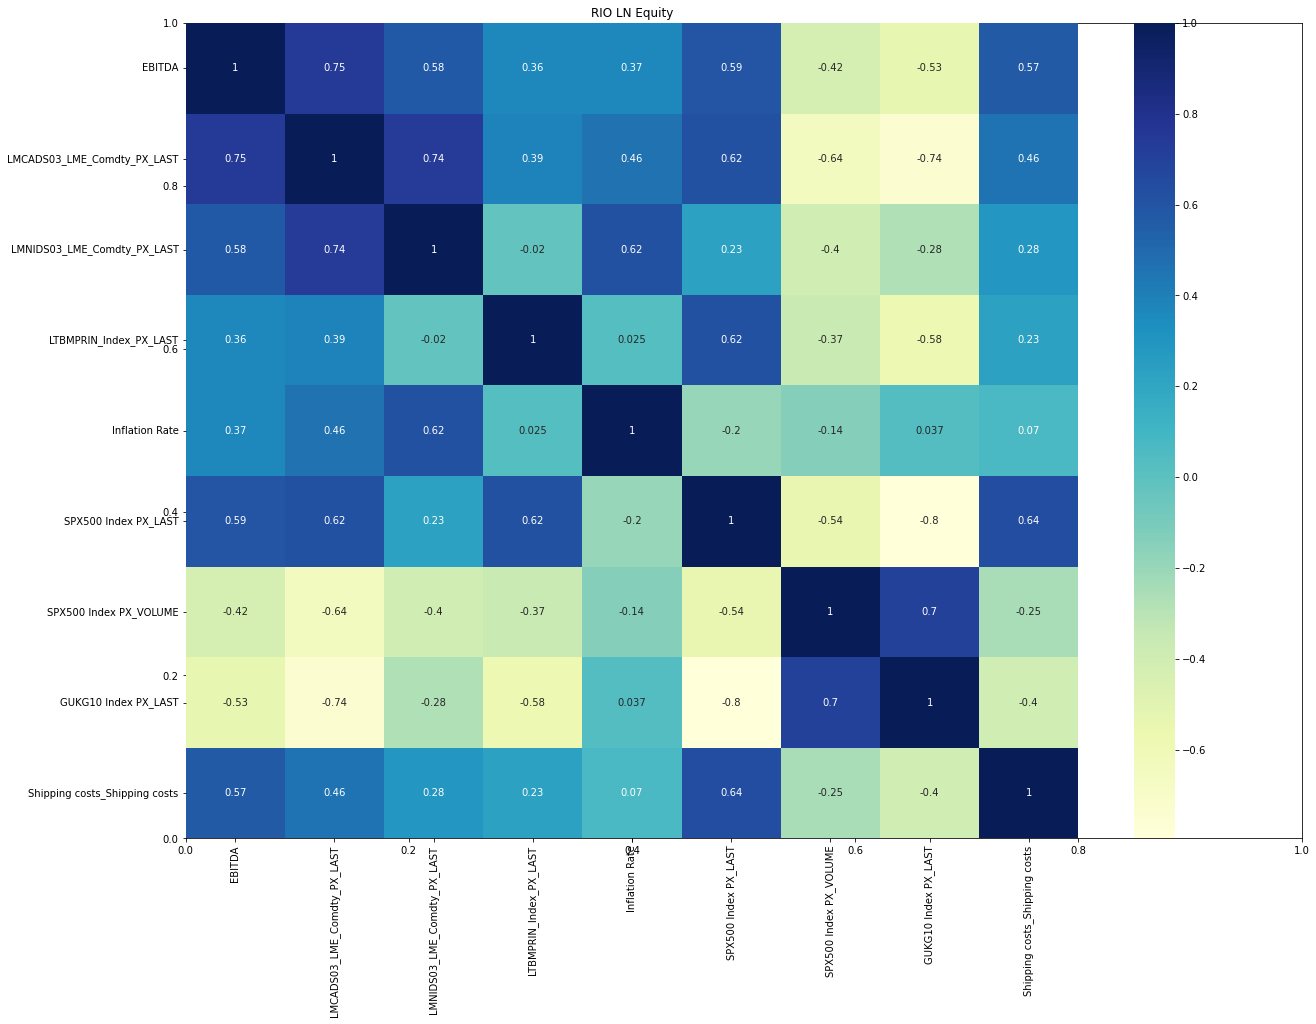

In [26]:
plt.subplots(figsize=(20,15))
ax = plt.axes()
ax.set_title("RIO LN Equity")
heatmap = sb.heatmap(RIO_final.corr(), cmap="YlGnBu", annot=True)

## LSTM with one feature removed from highly linearly correlated features

In [27]:
values = RIO_final.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# Lag is number of datapoints it looks previously
lag = 2
reframed = series_to_supervised(scaled, lag, 1)
#reframed.drop(reframed.columns[range(len(RIO_full.columns) + 1, 2*len(RIO_full.columns))], axis=1, inplace=True)
values = reframed.values
n_train_hours = 30
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = lag * len(RIO_final.columns)
train_X, train_y = train[:, :n_obs], train[:, -len(RIO_final.columns)]
test_X, test_y = test[:, :n_obs], test[:, -len(RIO_final.columns)]
# reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], lag, train_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0], lag, test_X.shape[1]))

train_X = train_X.reshape((train_X.shape[0], lag, len(RIO_final.columns)))
test_X = test_X.reshape((test_X.shape[0], lag, len(RIO_final.columns)))

# design network
model = Sequential()
lstm = LSTM(50, input_shape = (train_X.shape[1], train_X.shape[2]))
model.add(lstm)
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], lag*len(RIO_final.columns)))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -len(RIO_final.columns) + 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -len(RIO_final.columns) + 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
rmseAllFeatures = math.sqrt(mean_squared_error(inv_y, inv_yhat))

rmseList = []
for i in range(1, len(RIO_final.columns)):
    RIO_dropFeature = RIO_final.drop([RIO_final.columns[i]], axis = 1)
    values = RIO_dropFeature.values
    values = values.astype('float32')
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

    # Lag is number of datapoints it looks previously
    lag = 2
    reframed = series_to_supervised(scaled, lag, 1)
    #reframed.drop(reframed.columns[range(len(RIO_full.columns) + 1, 2*len(RIO_full.columns))], axis=1, inplace=True)
    values = reframed.values
    n_train_hours = 30
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    n_obs = lag * len(RIO_dropFeature.columns)
    train_X, train_y = train[:, :n_obs], train[:, -len(RIO_dropFeature.columns)]
    test_X, test_y = test[:, :n_obs], test[:, -len(RIO_dropFeature.columns)]
    # reshape input to be 3D [samples, timesteps, features]
    # train_X = train_X.reshape((train_X.shape[0], lag, train_X.shape[1]))
    # test_X = test_X.reshape((test_X.shape[0], lag, test_X.shape[1]))

    train_X = train_X.reshape((train_X.shape[0], lag, len(RIO_dropFeature.columns)))
    test_X = test_X.reshape((test_X.shape[0], lag, len(RIO_dropFeature.columns)))
    
    # design network
    model = Sequential()
    lstm = LSTM(50, input_shape = (train_X.shape[1], train_X.shape[2]))
    model.add(lstm)
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], lag*len(RIO_dropFeature.columns)))
    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat, test_X[:, -len(RIO_dropFeature.columns) + 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X[:, -len(RIO_dropFeature.columns) + 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    rmse = math.sqrt(mean_squared_error(test_y, yhat))
    rmseList.append(rmse)

Epoch 1/50
1/1 - 1s - loss: 0.4298 - val_loss: 0.5430
Epoch 2/50
1/1 - 0s - loss: 0.4098 - val_loss: 0.5203
Epoch 3/50
1/1 - 0s - loss: 0.3898 - val_loss: 0.4976
Epoch 4/50
1/1 - 0s - loss: 0.3698 - val_loss: 0.4748
Epoch 5/50
1/1 - 0s - loss: 0.3497 - val_loss: 0.4519
Epoch 6/50
1/1 - 0s - loss: 0.3296 - val_loss: 0.4289
Epoch 7/50
1/1 - 0s - loss: 0.3094 - val_loss: 0.4058
Epoch 8/50
1/1 - 0s - loss: 0.2891 - val_loss: 0.3825
Epoch 9/50
1/1 - 0s - loss: 0.2687 - val_loss: 0.3590
Epoch 10/50
1/1 - 0s - loss: 0.2482 - val_loss: 0.3353
Epoch 11/50
1/1 - 0s - loss: 0.2274 - val_loss: 0.3112
Epoch 12/50
1/1 - 0s - loss: 0.2065 - val_loss: 0.2869
Epoch 13/50
1/1 - 0s - loss: 0.1853 - val_loss: 0.2622
Epoch 14/50
1/1 - 0s - loss: 0.1642 - val_loss: 0.2373
Epoch 15/50
1/1 - 0s - loss: 0.1448 - val_loss: 0.2121
Epoch 16/50
1/1 - 0s - loss: 0.1266 - val_loss: 0.1867
Epoch 17/50
1/1 - 0s - loss: 0.1099 - val_loss: 0.1612
Epoch 18/50
1/1 - 0s - loss: 0.0945 - val_loss: 0.1393
Epoch 19/50
1/1 - 0

Epoch 1/50
1/1 - 1s - loss: 0.4674 - val_loss: 0.6121
Epoch 2/50
1/1 - 0s - loss: 0.4454 - val_loss: 0.5909
Epoch 3/50
1/1 - 0s - loss: 0.4236 - val_loss: 0.5698
Epoch 4/50
1/1 - 0s - loss: 0.4030 - val_loss: 0.5489
Epoch 5/50
1/1 - 0s - loss: 0.3829 - val_loss: 0.5281
Epoch 6/50
1/1 - 0s - loss: 0.3630 - val_loss: 0.5073
Epoch 7/50
1/1 - 0s - loss: 0.3431 - val_loss: 0.4866
Epoch 8/50
1/1 - 0s - loss: 0.3232 - val_loss: 0.4657
Epoch 9/50
1/1 - 0s - loss: 0.3032 - val_loss: 0.4448
Epoch 10/50
1/1 - 0s - loss: 0.2833 - val_loss: 0.4237
Epoch 11/50
1/1 - 0s - loss: 0.2632 - val_loss: 0.4025
Epoch 12/50
1/1 - 0s - loss: 0.2429 - val_loss: 0.3810
Epoch 13/50
1/1 - 0s - loss: 0.2225 - val_loss: 0.3592
Epoch 14/50
1/1 - 0s - loss: 0.2019 - val_loss: 0.3372
Epoch 15/50
1/1 - 0s - loss: 0.1809 - val_loss: 0.3148
Epoch 16/50
1/1 - 0s - loss: 0.1597 - val_loss: 0.2921
Epoch 17/50
1/1 - 0s - loss: 0.1389 - val_loss: 0.2690
Epoch 18/50
1/1 - 0s - loss: 0.1220 - val_loss: 0.2459
Epoch 19/50
1/1 - 0

Epoch 9/50
1/1 - 0s - loss: 0.1837 - val_loss: 0.4816
Epoch 10/50
1/1 - 0s - loss: 0.1630 - val_loss: 0.4601
Epoch 11/50
1/1 - 0s - loss: 0.1484 - val_loss: 0.4389
Epoch 12/50
1/1 - 0s - loss: 0.1384 - val_loss: 0.4180
Epoch 13/50
1/1 - 0s - loss: 0.1303 - val_loss: 0.3976
Epoch 14/50
1/1 - 0s - loss: 0.1260 - val_loss: 0.3783
Epoch 15/50
1/1 - 0s - loss: 0.1236 - val_loss: 0.3603
Epoch 16/50
1/1 - 0s - loss: 0.1232 - val_loss: 0.3437
Epoch 17/50
1/1 - 0s - loss: 0.1232 - val_loss: 0.3286
Epoch 18/50
1/1 - 0s - loss: 0.1235 - val_loss: 0.3150
Epoch 19/50
1/1 - 0s - loss: 0.1235 - val_loss: 0.3027
Epoch 20/50
1/1 - 0s - loss: 0.1234 - val_loss: 0.2920
Epoch 21/50
1/1 - 0s - loss: 0.1246 - val_loss: 0.2836
Epoch 22/50
1/1 - 0s - loss: 0.1251 - val_loss: 0.2772
Epoch 23/50
1/1 - 0s - loss: 0.1247 - val_loss: 0.2728
Epoch 24/50
1/1 - 0s - loss: 0.1240 - val_loss: 0.2704
Epoch 25/50
1/1 - 0s - loss: 0.1223 - val_loss: 0.2700
Epoch 26/50
1/1 - 0s - loss: 0.1197 - val_loss: 0.2713
Epoch 27/50

Epoch 31/50
1/1 - 0s - loss: 0.0979 - val_loss: 0.1211
Epoch 32/50
1/1 - 0s - loss: 0.0997 - val_loss: 0.1222
Epoch 33/50
1/1 - 0s - loss: 0.1000 - val_loss: 0.1216
Epoch 34/50
1/1 - 0s - loss: 0.0990 - val_loss: 0.1195
Epoch 35/50
1/1 - 0s - loss: 0.0969 - val_loss: 0.1163
Epoch 36/50
1/1 - 0s - loss: 0.0939 - val_loss: 0.1137
Epoch 37/50
1/1 - 0s - loss: 0.0904 - val_loss: 0.1121
Epoch 38/50
1/1 - 0s - loss: 0.0870 - val_loss: 0.1128
Epoch 39/50
1/1 - 0s - loss: 0.0837 - val_loss: 0.1142
Epoch 40/50
1/1 - 0s - loss: 0.0815 - val_loss: 0.1156
Epoch 41/50
1/1 - 0s - loss: 0.0796 - val_loss: 0.1170
Epoch 42/50
1/1 - 0s - loss: 0.0784 - val_loss: 0.1183
Epoch 43/50
1/1 - 0s - loss: 0.0775 - val_loss: 0.1194
Epoch 44/50
1/1 - 0s - loss: 0.0765 - val_loss: 0.1206
Epoch 45/50
1/1 - 0s - loss: 0.0756 - val_loss: 0.1216
Epoch 46/50
1/1 - 0s - loss: 0.0750 - val_loss: 0.1226
Epoch 47/50
1/1 - 0s - loss: 0.0747 - val_loss: 0.1232
Epoch 48/50
1/1 - 0s - loss: 0.0757 - val_loss: 0.1237
Epoch 49/5

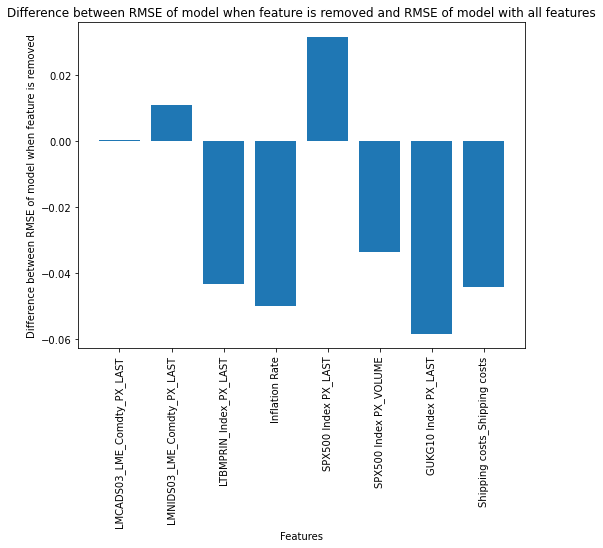

In [28]:
plt.bar(x = RIO_final.columns[1:], height = [rmse - rmseFullFeatures for rmse in rmseList])
plt.xticks(rotation = 90)
plt.xlabel("Features")
plt.ylabel("Difference between RMSE of model when feature is removed")
plt.title("Difference between RMSE of model when feature is removed and RMSE of model with all features")
plt.show()

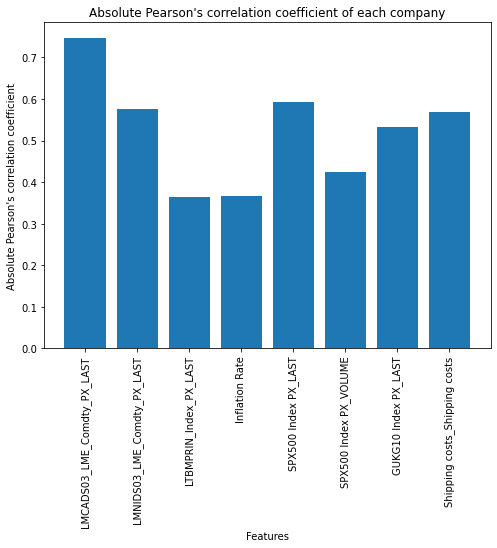

In [29]:
plt.bar(x = RIO_final.columns[1:], height = abs(RIO_final.corr()['EBITDA'][1:].values))
plt.xticks(rotation = 90)
plt.ylabel("Absolute Pearson's correlation coefficient")
plt.xlabel("Features")
plt.title("Absolute Pearson's correlation coefficient of each company")
plt.show()

In [30]:
rmseComp = dict(zip(RIO_final.columns[1:], [rmse - rmseFullFeatures for rmse in rmseList]))
rmseComp

{'LMCADS03_LME_Comdty_PX_LAST': 0.00032076477177184204,
 'LMNIDS03_LME_Comdty_PX_LAST': 0.010935580723366922,
 'LTBMPRIN_Index_PX_LAST': -0.04315704306061993,
 'Inflation Rate': -0.050040475668866574,
 'SPX500 Index PX_LAST': 0.03141462201393491,
 'SPX500 Index PX_VOLUME': -0.03345264042976273,
 'GUKG10 Index PX_LAST': -0.05824027875366028,
 'Shipping costs_Shipping costs': -0.04411765345039359}

## LSTM removed one feature with all features

In [31]:
values = RIO_full.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# Lag is number of datapoints it looks previously
lag = 2
reframed = series_to_supervised(scaled, lag, 1)
#reframed.drop(reframed.columns[range(len(RIO_full.columns) + 1, 2*len(RIO_full.columns))], axis=1, inplace=True)
values = reframed.values
n_train_hours = 30
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = lag * len(RIO_full.columns)
train_X, train_y = train[:, :n_obs], train[:, -len(RIO_full.columns)]
test_X, test_y = test[:, :n_obs], test[:, -len(RIO_full.columns)]
# reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], lag, train_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0], lag, test_X.shape[1]))

train_X = train_X.reshape((train_X.shape[0], lag, len(RIO_full.columns)))
test_X = test_X.reshape((test_X.shape[0], lag, len(RIO_full.columns)))

# design network
model = Sequential()
lstm = LSTM(50, input_shape = (train_X.shape[1], train_X.shape[2]))
model.add(lstm)
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], lag*len(RIO_full.columns)))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -len(RIO_full.columns) + 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -len(RIO_full.columns) + 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
rmseAllFeatures = math.sqrt(mean_squared_error(inv_y, inv_yhat))

rmseList = []
for i in range(1, len(RIO_full.columns)):
    RIO_dropFeature = RIO_full.drop([RIO_full.columns[i]], axis = 1)
    values = RIO_dropFeature.values
    values = values.astype('float32')
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

    # Lag is number of datapoints it looks previously
    lag = 2
    reframed = series_to_supervised(scaled, lag, 1)
    #reframed.drop(reframed.columns[range(len(RIO_full.columns) + 1, 2*len(RIO_full.columns))], axis=1, inplace=True)
    values = reframed.values
    n_train_hours = 30
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    n_obs = lag * len(RIO_dropFeature.columns)
    train_X, train_y = train[:, :n_obs], train[:, -len(RIO_dropFeature.columns)]
    test_X, test_y = test[:, :n_obs], test[:, -len(RIO_dropFeature.columns)]
    # reshape input to be 3D [samples, timesteps, features]
    # train_X = train_X.reshape((train_X.shape[0], lag, train_X.shape[1]))
    # test_X = test_X.reshape((test_X.shape[0], lag, test_X.shape[1]))

    train_X = train_X.reshape((train_X.shape[0], lag, len(RIO_dropFeature.columns)))
    test_X = test_X.reshape((test_X.shape[0], lag, len(RIO_dropFeature.columns)))
    
    # design network
    model = Sequential()
    lstm = LSTM(50, input_shape = (train_X.shape[1], train_X.shape[2]))
    model.add(lstm)
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], lag*len(RIO_dropFeature.columns)))
    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat, test_X[:, -len(RIO_dropFeature.columns) + 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X[:, -len(RIO_dropFeature.columns) + 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    rmse = math.sqrt(mean_squared_error(test_y, yhat))
    rmseList.append(rmse)

Epoch 1/50
1/1 - 1s - loss: 0.3539 - val_loss: 0.5317
Epoch 2/50
1/1 - 0s - loss: 0.3116 - val_loss: 0.4856
Epoch 3/50
1/1 - 0s - loss: 0.2693 - val_loss: 0.4395
Epoch 4/50
1/1 - 0s - loss: 0.2270 - val_loss: 0.3933
Epoch 5/50
1/1 - 0s - loss: 0.1845 - val_loss: 0.3468
Epoch 6/50
1/1 - 0s - loss: 0.1473 - val_loss: 0.3011
Epoch 7/50
1/1 - 0s - loss: 0.1221 - val_loss: 0.2567
Epoch 8/50
1/1 - 0s - loss: 0.1051 - val_loss: 0.2142
Epoch 9/50
1/1 - 0s - loss: 0.0980 - val_loss: 0.1758
Epoch 10/50
1/1 - 0s - loss: 0.0997 - val_loss: 0.1542
Epoch 11/50
1/1 - 0s - loss: 0.1074 - val_loss: 0.1413
Epoch 12/50
1/1 - 0s - loss: 0.1173 - val_loss: 0.1341
Epoch 13/50
1/1 - 0s - loss: 0.1245 - val_loss: 0.1321
Epoch 14/50
1/1 - 0s - loss: 0.1257 - val_loss: 0.1342
Epoch 15/50
1/1 - 0s - loss: 0.1214 - val_loss: 0.1396
Epoch 16/50
1/1 - 0s - loss: 0.1128 - val_loss: 0.1473
Epoch 17/50
1/1 - 0s - loss: 0.1020 - val_loss: 0.1565
Epoch 18/50
1/1 - 0s - loss: 0.0915 - val_loss: 0.1672
Epoch 19/50
1/1 - 0

Epoch 23/50
1/1 - 0s - loss: 0.0782 - val_loss: 0.2714
Epoch 24/50
1/1 - 0s - loss: 0.0812 - val_loss: 0.2716
Epoch 25/50
1/1 - 0s - loss: 0.0824 - val_loss: 0.2668
Epoch 26/50
1/1 - 0s - loss: 0.0806 - val_loss: 0.2575
Epoch 27/50
1/1 - 0s - loss: 0.0760 - val_loss: 0.2442
Epoch 28/50
1/1 - 0s - loss: 0.0696 - val_loss: 0.2283
Epoch 29/50
1/1 - 0s - loss: 0.0653 - val_loss: 0.2117
Epoch 30/50
1/1 - 0s - loss: 0.0644 - val_loss: 0.1968
Epoch 31/50
1/1 - 0s - loss: 0.0657 - val_loss: 0.1852
Epoch 32/50
1/1 - 0s - loss: 0.0684 - val_loss: 0.1776
Epoch 33/50
1/1 - 0s - loss: 0.0705 - val_loss: 0.1749
Epoch 34/50
1/1 - 0s - loss: 0.0713 - val_loss: 0.1775
Epoch 35/50
1/1 - 0s - loss: 0.0699 - val_loss: 0.1842
Epoch 36/50
1/1 - 0s - loss: 0.0669 - val_loss: 0.1931
Epoch 37/50
1/1 - 0s - loss: 0.0644 - val_loss: 0.2031
Epoch 38/50
1/1 - 0s - loss: 0.0634 - val_loss: 0.2121
Epoch 39/50
1/1 - 0s - loss: 0.0646 - val_loss: 0.2185
Epoch 40/50
1/1 - 0s - loss: 0.0658 - val_loss: 0.2228
Epoch 41/5

Epoch 45/50
1/1 - 0s - loss: 0.0646 - val_loss: 0.3016
Epoch 46/50
1/1 - 0s - loss: 0.0645 - val_loss: 0.3005
Epoch 47/50
1/1 - 0s - loss: 0.0642 - val_loss: 0.2985
Epoch 48/50
1/1 - 0s - loss: 0.0637 - val_loss: 0.2956
Epoch 49/50
1/1 - 0s - loss: 0.0630 - val_loss: 0.2919
Epoch 50/50
1/1 - 0s - loss: 0.0622 - val_loss: 0.2878
Epoch 1/50
1/1 - 1s - loss: 0.4963 - val_loss: 0.5704
Epoch 2/50
1/1 - 0s - loss: 0.4439 - val_loss: 0.5210
Epoch 3/50
1/1 - 0s - loss: 0.3952 - val_loss: 0.4716
Epoch 4/50
1/1 - 0s - loss: 0.3464 - val_loss: 0.4221
Epoch 5/50
1/1 - 0s - loss: 0.2977 - val_loss: 0.3725
Epoch 6/50
1/1 - 0s - loss: 0.2488 - val_loss: 0.3227
Epoch 7/50
1/1 - 0s - loss: 0.1996 - val_loss: 0.2726
Epoch 8/50
1/1 - 0s - loss: 0.1516 - val_loss: 0.2223
Epoch 9/50
1/1 - 0s - loss: 0.1073 - val_loss: 0.1861
Epoch 10/50
1/1 - 0s - loss: 0.0701 - val_loss: 0.1598
Epoch 11/50
1/1 - 0s - loss: 0.0670 - val_loss: 0.1383
Epoch 12/50
1/1 - 0s - loss: 0.0912 - val_loss: 0.1302
Epoch 13/50
1/1 - 0

Epoch 3/50
1/1 - 0s - loss: 0.0761 - val_loss: 0.2001
Epoch 4/50
1/1 - 0s - loss: 0.0717 - val_loss: 0.1668
Epoch 5/50
1/1 - 0s - loss: 0.0834 - val_loss: 0.1557
Epoch 6/50
1/1 - 0s - loss: 0.0918 - val_loss: 0.1559
Epoch 7/50
1/1 - 0s - loss: 0.0911 - val_loss: 0.1636
Epoch 8/50
1/1 - 0s - loss: 0.0845 - val_loss: 0.1790
Epoch 9/50
1/1 - 0s - loss: 0.0742 - val_loss: 0.1979
Epoch 10/50
1/1 - 0s - loss: 0.0687 - val_loss: 0.2163
Epoch 11/50
1/1 - 0s - loss: 0.0676 - val_loss: 0.2318
Epoch 12/50
1/1 - 0s - loss: 0.0707 - val_loss: 0.2416
Epoch 13/50
1/1 - 0s - loss: 0.0746 - val_loss: 0.2457
Epoch 14/50
1/1 - 0s - loss: 0.0765 - val_loss: 0.2431
Epoch 15/50
1/1 - 0s - loss: 0.0749 - val_loss: 0.2358
Epoch 16/50
1/1 - 0s - loss: 0.0714 - val_loss: 0.2252
Epoch 17/50
1/1 - 0s - loss: 0.0672 - val_loss: 0.2129
Epoch 18/50
1/1 - 0s - loss: 0.0644 - val_loss: 0.2009
Epoch 19/50
1/1 - 0s - loss: 0.0645 - val_loss: 0.1913
Epoch 20/50
1/1 - 0s - loss: 0.0658 - val_loss: 0.1859
Epoch 21/50
1/1 -

Epoch 25/50
1/1 - 0s - loss: 0.0806 - val_loss: 0.1860
Epoch 26/50
1/1 - 0s - loss: 0.0834 - val_loss: 0.1928
Epoch 27/50
1/1 - 0s - loss: 0.0875 - val_loss: 0.1946
Epoch 28/50
1/1 - 0s - loss: 0.0891 - val_loss: 0.1917
Epoch 29/50
1/1 - 0s - loss: 0.0881 - val_loss: 0.1849
Epoch 30/50
1/1 - 0s - loss: 0.0846 - val_loss: 0.1743
Epoch 31/50
1/1 - 0s - loss: 0.0797 - val_loss: 0.1618
Epoch 32/50
1/1 - 0s - loss: 0.0747 - val_loss: 0.1504
Epoch 33/50
1/1 - 0s - loss: 0.0713 - val_loss: 0.1389
Epoch 34/50
1/1 - 0s - loss: 0.0690 - val_loss: 0.1276
Epoch 35/50
1/1 - 0s - loss: 0.0692 - val_loss: 0.1206
Epoch 36/50
1/1 - 0s - loss: 0.0708 - val_loss: 0.1153
Epoch 37/50
1/1 - 0s - loss: 0.0730 - val_loss: 0.1121
Epoch 38/50
1/1 - 0s - loss: 0.0739 - val_loss: 0.1107
Epoch 39/50
1/1 - 0s - loss: 0.0736 - val_loss: 0.1110
Epoch 40/50
1/1 - 0s - loss: 0.0723 - val_loss: 0.1129
Epoch 41/50
1/1 - 0s - loss: 0.0700 - val_loss: 0.1162
Epoch 42/50
1/1 - 0s - loss: 0.0672 - val_loss: 0.1204
Epoch 43/5

Epoch 47/50
1/1 - 0s - loss: 0.0635 - val_loss: 0.2507
Epoch 48/50
1/1 - 0s - loss: 0.0622 - val_loss: 0.2442
Epoch 49/50
1/1 - 0s - loss: 0.0609 - val_loss: 0.2384
Epoch 50/50
1/1 - 0s - loss: 0.0608 - val_loss: 0.2337
Epoch 1/50
1/1 - 1s - loss: 0.2723 - val_loss: 0.3259
Epoch 2/50
1/1 - 0s - loss: 0.2263 - val_loss: 0.2740
Epoch 3/50
1/1 - 0s - loss: 0.1829 - val_loss: 0.2220
Epoch 4/50
1/1 - 0s - loss: 0.1414 - val_loss: 0.1696
Epoch 5/50
1/1 - 0s - loss: 0.1061 - val_loss: 0.1383
Epoch 6/50
1/1 - 0s - loss: 0.0839 - val_loss: 0.1162
Epoch 7/50
1/1 - 0s - loss: 0.0808 - val_loss: 0.1111
Epoch 8/50
1/1 - 0s - loss: 0.0932 - val_loss: 0.1123
Epoch 9/50
1/1 - 0s - loss: 0.1058 - val_loss: 0.1140
Epoch 10/50
1/1 - 0s - loss: 0.1112 - val_loss: 0.1119
Epoch 11/50
1/1 - 0s - loss: 0.1066 - val_loss: 0.1105
Epoch 12/50
1/1 - 0s - loss: 0.0953 - val_loss: 0.1134
Epoch 13/50
1/1 - 0s - loss: 0.0835 - val_loss: 0.1171
Epoch 14/50
1/1 - 0s - loss: 0.0738 - val_loss: 0.1288
Epoch 15/50
1/1 - 0

Epoch 5/50
1/1 - 0s - loss: 0.1067 - val_loss: 0.2328
Epoch 6/50
1/1 - 0s - loss: 0.0846 - val_loss: 0.1839
Epoch 7/50
1/1 - 0s - loss: 0.0763 - val_loss: 0.1524
Epoch 8/50
1/1 - 0s - loss: 0.0892 - val_loss: 0.1369
Epoch 9/50
1/1 - 0s - loss: 0.1051 - val_loss: 0.1287
Epoch 10/50
1/1 - 0s - loss: 0.1160 - val_loss: 0.1273
Epoch 11/50
1/1 - 0s - loss: 0.1172 - val_loss: 0.1312
Epoch 12/50
1/1 - 0s - loss: 0.1107 - val_loss: 0.1390
Epoch 13/50
1/1 - 0s - loss: 0.0990 - val_loss: 0.1492
Epoch 14/50
1/1 - 0s - loss: 0.0865 - val_loss: 0.1611
Epoch 15/50
1/1 - 0s - loss: 0.0745 - val_loss: 0.1811
Epoch 16/50
1/1 - 0s - loss: 0.0678 - val_loss: 0.2019
Epoch 17/50
1/1 - 0s - loss: 0.0680 - val_loss: 0.2187
Epoch 18/50
1/1 - 0s - loss: 0.0704 - val_loss: 0.2304
Epoch 19/50
1/1 - 0s - loss: 0.0758 - val_loss: 0.2356
Epoch 20/50
1/1 - 0s - loss: 0.0796 - val_loss: 0.2344
Epoch 21/50
1/1 - 0s - loss: 0.0793 - val_loss: 0.2274
Epoch 22/50
1/1 - 0s - loss: 0.0746 - val_loss: 0.2156
Epoch 23/50
1/1

Epoch 27/50
1/1 - 0s - loss: 0.0770 - val_loss: 0.2574
Epoch 28/50
1/1 - 0s - loss: 0.0786 - val_loss: 0.2626
Epoch 29/50
1/1 - 0s - loss: 0.0796 - val_loss: 0.2649
Epoch 30/50
1/1 - 0s - loss: 0.0799 - val_loss: 0.2648
Epoch 31/50
1/1 - 0s - loss: 0.0793 - val_loss: 0.2619
Epoch 32/50
1/1 - 0s - loss: 0.0781 - val_loss: 0.2566
Epoch 33/50
1/1 - 0s - loss: 0.0757 - val_loss: 0.2487
Epoch 34/50
1/1 - 0s - loss: 0.0721 - val_loss: 0.2388
Epoch 35/50
1/1 - 0s - loss: 0.0681 - val_loss: 0.2278
Epoch 36/50
1/1 - 0s - loss: 0.0652 - val_loss: 0.2167
Epoch 37/50
1/1 - 0s - loss: 0.0632 - val_loss: 0.2055
Epoch 38/50
1/1 - 0s - loss: 0.0622 - val_loss: 0.1954
Epoch 39/50
1/1 - 0s - loss: 0.0618 - val_loss: 0.1901
Epoch 40/50
1/1 - 0s - loss: 0.0615 - val_loss: 0.1859
Epoch 41/50
1/1 - 0s - loss: 0.0629 - val_loss: 0.1832
Epoch 42/50
1/1 - 0s - loss: 0.0636 - val_loss: 0.1822
Epoch 43/50
1/1 - 0s - loss: 0.0636 - val_loss: 0.1827
Epoch 44/50
1/1 - 0s - loss: 0.0627 - val_loss: 0.1844
Epoch 45/5

Epoch 49/50
1/1 - 0s - loss: 0.0674 - val_loss: 0.1900
Epoch 50/50
1/1 - 0s - loss: 0.0677 - val_loss: 0.1890
Epoch 1/50
1/1 - 1s - loss: 0.4097 - val_loss: 0.4658
Epoch 2/50
1/1 - 0s - loss: 0.3608 - val_loss: 0.4142
Epoch 3/50
1/1 - 0s - loss: 0.3118 - val_loss: 0.3625
Epoch 4/50
1/1 - 0s - loss: 0.2626 - val_loss: 0.3104
Epoch 5/50
1/1 - 0s - loss: 0.2133 - val_loss: 0.2578
Epoch 6/50
1/1 - 0s - loss: 0.1636 - val_loss: 0.2044
Epoch 7/50
1/1 - 0s - loss: 0.1182 - val_loss: 0.1625
Epoch 8/50
1/1 - 0s - loss: 0.0789 - val_loss: 0.1341
Epoch 9/50
1/1 - 0s - loss: 0.0686 - val_loss: 0.1151
Epoch 10/50
1/1 - 0s - loss: 0.0855 - val_loss: 0.1157
Epoch 11/50
1/1 - 0s - loss: 0.1073 - val_loss: 0.1225
Epoch 12/50
1/1 - 0s - loss: 0.1226 - val_loss: 0.1255
Epoch 13/50
1/1 - 0s - loss: 0.1290 - val_loss: 0.1233
Epoch 14/50
1/1 - 0s - loss: 0.1261 - val_loss: 0.1175
Epoch 15/50
1/1 - 0s - loss: 0.1165 - val_loss: 0.1121
Epoch 16/50
1/1 - 0s - loss: 0.1031 - val_loss: 0.1143
Epoch 17/50
1/1 - 0

Epoch 7/50
1/1 - 0s - loss: 0.1171 - val_loss: 0.2157
Epoch 8/50
1/1 - 0s - loss: 0.0817 - val_loss: 0.1789
Epoch 9/50
1/1 - 0s - loss: 0.0756 - val_loss: 0.1549
Epoch 10/50
1/1 - 0s - loss: 0.0896 - val_loss: 0.1394
Epoch 11/50
1/1 - 0s - loss: 0.1052 - val_loss: 0.1313
Epoch 12/50
1/1 - 0s - loss: 0.1193 - val_loss: 0.1324
Epoch 13/50
1/1 - 0s - loss: 0.1275 - val_loss: 0.1321
Epoch 14/50
1/1 - 0s - loss: 0.1264 - val_loss: 0.1306
Epoch 15/50
1/1 - 0s - loss: 0.1181 - val_loss: 0.1351
Epoch 16/50
1/1 - 0s - loss: 0.1068 - val_loss: 0.1410
Epoch 17/50
1/1 - 0s - loss: 0.0955 - val_loss: 0.1506
Epoch 18/50
1/1 - 0s - loss: 0.0847 - val_loss: 0.1623
Epoch 19/50
1/1 - 0s - loss: 0.0749 - val_loss: 0.1739
Epoch 20/50
1/1 - 0s - loss: 0.0693 - val_loss: 0.1847
Epoch 21/50
1/1 - 0s - loss: 0.0699 - val_loss: 0.1945
Epoch 22/50
1/1 - 0s - loss: 0.0757 - val_loss: 0.2055
Epoch 23/50
1/1 - 0s - loss: 0.0828 - val_loss: 0.2101
Epoch 24/50
1/1 - 0s - loss: 0.0866 - val_loss: 0.2091
Epoch 25/50
1

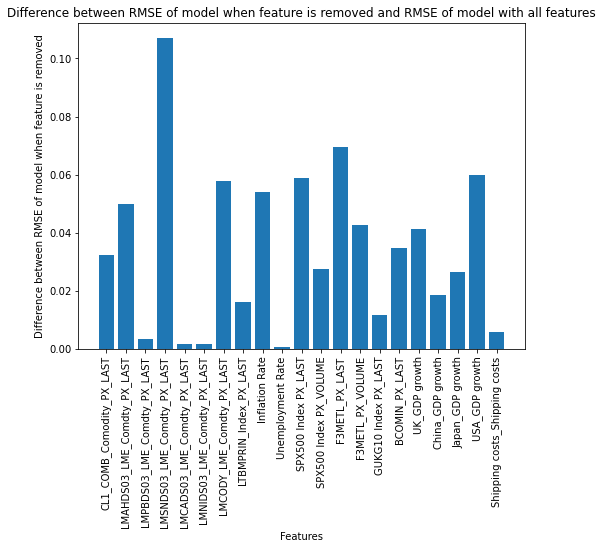

In [32]:
plt.bar(x = RIO_full.columns[1:], height = [abs(rmse - rmseFullFeatures) for rmse in rmseList])
plt.xticks(rotation = 90)
plt.xlabel("Features")
plt.ylabel("Difference between RMSE of model when feature is removed")
plt.title("Difference between RMSE of model when feature is removed and RMSE of model with all features")
plt.show()

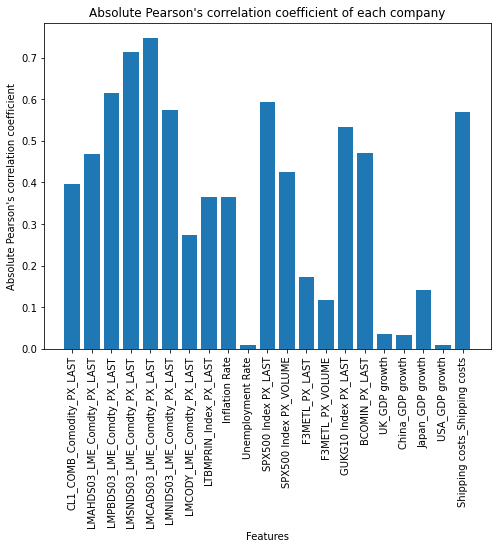

In [33]:
plt.bar(x = RIO_full.columns[1:], height = abs(RIO_full.corr()['EBITDA'][1:].values))
plt.xticks(rotation = 90)
plt.ylabel("Absolute Pearson's correlation coefficient")
plt.xlabel("Features")
plt.title("Absolute Pearson's correlation coefficient of each company")
plt.show()

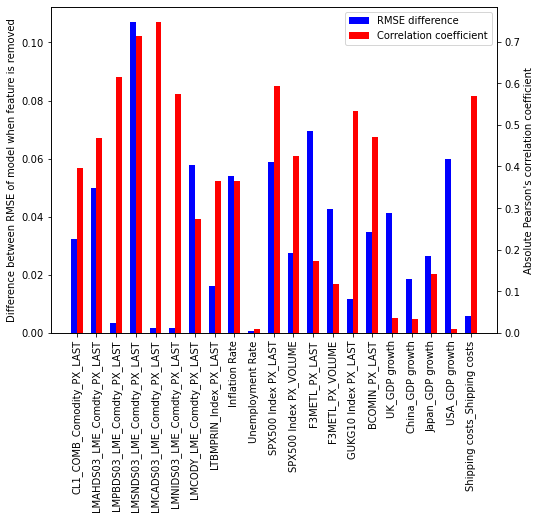

In [34]:
x = np.arange(len(RIO_full.columns) - 1)
ax1 = plt.subplot()
w = 0.3
#plt.xticks(), will label the bars on x axis with the respective country names.
plt.xticks(x + w /2, RIO_full.columns[1:], rotation='vertical')
modelAccuracy =ax1.bar(x, [abs(rmse - rmseFullFeatures) for rmse in rmseList], width=w, color='b', align='center')
plt.ylabel("Difference between RMSE of model when feature is removed")
#The trick is to use two different axes that share the same x axis, we have used ax1.twinx() method.
ax2 = ax1.twinx()

correlation = ax2.bar(x + w, abs(RIO_full.corr()['EBITDA'][1:].values), width=w,color='r',align='center')

plt.ylabel("Absolute Pearson's correlation coefficient")
#To set the legend on the plot we have used plt.legend()
plt.legend([modelAccuracy, correlation],["RMSE difference", "Correlation coefficient"])
#To show the plot finally we have used plt.show().
plt.show()